<a href="https://colab.research.google.com/github/Xuan-He-97/Neural-networks-and-quantum-field-theory/blob/main/Experiments/Chapter4/4_3_Flows_in_Single_layer_networks_ReLU_net_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import pickle
import pathlib
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy.special import erf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.integrate import quad
from tqdm import tqdm

In [ ]:
from google.colab import drive
# log in to the google drive account
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
X_ReLU = np.array([[0.2], [0.4], [0.6], [0.8], [1.0], [1.2]])

### Find all distinct combination of $G^{(n)}$

In [ ]:
def findsubsets(X, n):
    res = []
    for i1 in range(n+1):
        for i2 in range(n+1-i1):
            for i3 in range(n+1-i1-i2):
                for i4 in range(n+1-i1-i2-i3):
                    for i5 in range(n+1-i1-i2-i3-i4):
                        i6 = n-i1-i2-i3-i4-i5
                        res.append([X[0]]*i1 + [X[1]]*i2 + [X[2]]*i3 + [X[3]]*i4 + [X[4]]*i5 + [X[5]]*i6)
    return res

In [ ]:
comb2 = findsubsets([i for i in range(6)], 2)
print(len(comb2))
comb4 = findsubsets([i for i in range(6)], 4)
print(len(comb4))
comb6 = findsubsets([i for i in range(6)], 6)
print(len(comb6))

21
126
462


### $\Delta_{1234y}$

In [ ]:
def integrand4(t, x1, x2, x3, x4, K):
    return K(x1, t) * K(x2, t) * K(x3, t) * K(x4, t)

### $\int d^{d_{in}}y \; \Delta_{1234y}$

In [ ]:
def compute_integral4(X, comb, K, Lambda, integrand=integrand4):
    res = []
    for c in comb:
        x1, x2, x3, x4 = X[c]
        res.append(quad(integrand, 0, Lambda, args=(x1, x2, x3, x4, K))[0])
    return dict(zip([tuple(c) for c in comb], res))

### $\Delta_{1234,y,56}$

In [ ]:
def integrand6(t, x1, x2, x3, x4, x5, x6, K):
    return K(x1, t) * K(x2, t) * K(x3, t) * K(x4, t) * K(x5, x6)

### $\Sigma\int d^{d_{in}}y \; \Delta_{1234,y,56}$

In [ ]:
def compute_integral6(X, comb, K, Lambda, integrand=integrand6):
    res = []
    wick_pairs24 = [[1, 2, 3, 4, 5, 6], [1, 3, 2, 4, 5, 6], [1, 4, 2, 3, 5, 6], [1, 5, 2, 3, 4, 6], [1, 6, 2, 3, 4, 5], 
                    [2, 3, 1, 4, 5, 6], [2, 4, 1, 3, 5, 6], [2, 5, 1, 3, 4, 6], [2, 6, 1, 3, 4, 5], [3, 4, 1, 2, 5, 6], 
                    [3, 5, 1, 2, 4, 6], [3, 6, 1, 2, 4, 5], [4, 5, 1, 2, 3, 6], [4, 6, 1, 2, 3, 5], [5, 6, 1, 2, 3, 4]]
    for c in comb:
        inte = 0
        for idx in wick_pairs24:
            idx = [i-1 for i in idx]
            x1, x2, x3, x4 = X[c][idx[2:]]
            x5, x6 = X[c][idx[:2]]
            inte += quad(integrand, 0, Lambda, args=(x1, x2, x3, x4, x5, x6, K))[0]
        res.append(inte)
    return dict(zip([tuple(c) for c in comb], res))

## ReLU-net

### ReLU-net $K(x_i, x_j)$ and $K_W(x_i, x_j)$

In [ ]:
def K_ReLU(x, y, sigmab2=0.0, sigmaw2=1.0, d_in=1.0):
    xy = np.dot(x, y)
    xx = np.dot(x, x)
    yy = np.dot(y, y)
    corr = np.sqrt((sigmab2 + sigmaw2*xx/d_in) * (sigmab2 + sigmaw2*yy/d_in))
    costheta = (sigmab2 + sigmaw2*xy/d_in) / corr
    theta = np.arccos(costheta)
    return sigmab2 + sigmaw2 * (1.0 / (2.0*np.pi)) * corr * (np.sin(theta) + (np.pi - theta) * costheta)

In [ ]:
def Kw_ReLU(x, y, sigmab2=0.0, sigmaw2=1.0, d_in=1.0):
    xy = np.dot(x, y)
    xx = np.dot(x, x)
    yy = np.dot(y, y)
    corr = np.sqrt((sigmab2 + 1e-11 + sigmaw2*xx/d_in) * (sigmab2 + 1e-11 + sigmaw2*yy/d_in))
    costheta = (sigmab2 + sigmaw2*xy/d_in) / corr
    costheta = np.minimum(costheta, 1)
    costheta = np.maximum(costheta, -1)
    theta = np.arccos(costheta)
    return sigmaw2 * (1.0 / (2.0*np.pi)) * corr * (np.sin(theta) + (np.pi - theta) * costheta)

In [ ]:
def costheta(x, y, sigmab2=0.0, sigmaw2=1.0, d_in=1.0):
    xy = np.dot(x, y)
    xx = np.dot(x, x)
    yy = np.dot(y, y)
    corr = np.sqrt((sigmab2 + 1e-11 + sigmaw2*xx/d_in) * (sigmab2 + 1e-11 + sigmaw2*yy/d_in))
    costheta = (sigmab2 + sigmaw2*xy/d_in) / corr
    costheta = np.minimum(costheta, 1)
    costheta = np.maximum(costheta, -1)
    return costheta

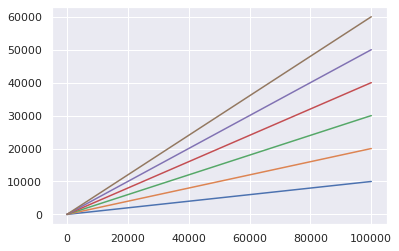

In [ ]:
x = np.linspace(0, 100000, 200)
y = []
for relu in X_ReLU.reshape(-1):
    y.append([Kw_ReLU(t, relu) for t in x])
y_df = pd.DataFrame(np.transpose(np.array(y)), index=x)
y_df.plot(legend=False)
plt.show()

### Compute $K_W(x_i, x_j)$ and save the results

In [ ]:
def compute_K(X, comb, K):
    K_values = []
    for c in comb:
        x1, x2 = X[c]
        K_values.append(K(x1, x2))
    return dict(zip([tuple(c) for c in comb], K_values))

In [ ]:
K_values = compute_K(X_ReLU.reshape(-1), comb2, K_ReLU)

In [ ]:
K_values

{(0, 0): 0.020000000000000004,
 (0, 1): 0.04000000000000001,
 (0, 2): 0.06,
 (0, 3): 0.08000000000000002,
 (0, 4): 0.09999999999999999,
 (0, 5): 0.12,
 (1, 1): 0.08000000000000002,
 (1, 2): 0.12,
 (1, 3): 0.16000000000000003,
 (1, 4): 0.19999999999999998,
 (1, 5): 0.24,
 (2, 2): 0.18,
 (2, 3): 0.24,
 (2, 4): 0.3,
 (2, 5): 0.36,
 (3, 3): 0.32000000000000006,
 (3, 4): 0.39999999999999997,
 (3, 5): 0.48,
 (4, 4): 0.5,
 (4, 5): 0.6,
 (5, 5): 0.72}

### Wick contraction

In [ ]:
def G_gp2(X, K):
    x1, x2 = X
    return K(x1, x2)

In [ ]:
def G_gp4(X, K):
    x1, x2, x3, x4 = X
    return K(x1, x2) * K(x3, x4) + K(x1, x3) * K(x2, x4) + K(x1, x4) * K(x2, x3)

In [ ]:
def G_gp6(X, K):
    wick_pairs = [[1, 2, 3, 4, 5, 6], [1, 2, 3, 5, 4, 6], [1, 2, 3, 6, 4, 5], [1, 3, 2, 4, 5, 6], [1, 3, 2, 5, 4, 6],
                  [1, 3, 2, 6, 4, 5], [1, 4, 2, 3, 5, 6], [1, 4, 2, 5, 3, 6], [1, 4, 2, 6, 3, 5], 
                  [1, 5, 2, 3, 4, 6], [1, 5, 2, 4, 3, 6],
                  [1, 5, 2, 6, 3, 4], [1, 6, 2, 3, 4, 5], [1, 6, 2, 4, 3, 5], [1, 6, 2, 5, 3, 4]]
    res = 0
    for x1, x2, x3, x4, x5, x6 in wick_pairs:
        res += K(X[x1-1], X[x2-1]) * K(X[x3-1], X[x4-1]) * K(X[x5-1], X[x6-1])
    return res

### Compute $G_{GP}^{(6)}$

In [ ]:
G_gp6_ReLU = []
for c in comb6:
    G_gp6_ReLU.append(G_gp6(X_ReLU.reshape(-1)[c], K_ReLU))
G_gp6_ReLU = dict(zip([tuple(c) for c in comb6], G_gp6_ReLU))

### Load experimental $G^{(4)}$ and $G^{(6)}$ result and compute $\lambda_m$

In [ ]:
dir = '/gdrive/MyDrive/NNGP/ReLU/'
files = list(pathlib.Path(dir).glob('*'))
lambdam4_ReLU = []
lambdam6_ReLU = []
G4_ReLU = []
G6_ReLU = []
file = pathlib.Path('/gdrive/MyDrive/NNGP/ReLU/fx_exp_20.pickle')
Lambda_list = [7, 10, 15, 20, 30, 40, 50, 70, 100, 200, 500, 1000, 2000, 5000, 7000, 10000, 20000, 40000, 60000, 80000, 100000]

with open(file, 'rb') as handle:
    fx_exp = pickle.load(handle).reshape(10000000, 6)

for c in comb4: 
    G4 = fx_exp[:, c].prod(1).mean()
    G4_ReLU.append(G4)
for c in comb6: 
    G6 = fx_exp[:, c].prod(1).mean()
    G6_ReLU.append(G6)

for Lambda in tqdm(Lambda_list):
    
    integral4_ReLU = compute_integral4(X_ReLU.reshape(-1), comb4, Kw_ReLU, Lambda)
    integral6_ReLU = compute_integral6(X_ReLU.reshape(-1), comb6, Kw_ReLU, Lambda)

    for i, c in enumerate(comb4): 
        A = K_values[(c[0], c[1])]*K_values[(c[2], c[3])] + K_values[(c[0], c[2])]*K_values[(c[1], c[3])] + K_values[(c[0], c[3])]*K_values[(c[1], c[2])]
        B = 24 * integral4_ReLU[tuple(c)]
        G4 = G4_ReLU[i]
        lambdam4_ReLU.append((A - G4) / B)
        
    for i, c in enumerate(comb6): 
        A = G_gp6_ReLU[tuple(c)]
        B = 24 * integral6_ReLU[tuple(c)]
        G6 = G6_ReLU[i]
        lambdam6_ReLU.append((A - G6) / B)

100%|██████████| 21/21 [04:11<00:00, 11.96s/it]


In [ ]:
lambdam4_ReLU_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125
0.845098,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,...,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069,-4.438069
1.000000,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,...,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578,-5.212578
1.176091,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,...,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035,-6.093035
1.301030,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,...,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728,-6.717728
1.477121,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,...,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.598185,-7.5

In [ ]:
lambdam4_ReLU_df = pd.DataFrame(np.log10(np.abs(lambdam4_ReLU).reshape(21, -1)))
lambdam4_ReLU_df.index = np.log10(Lambda_list)

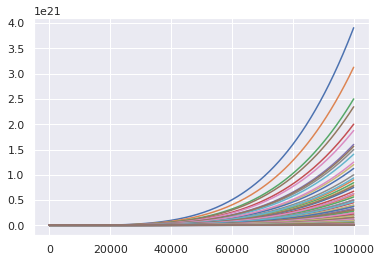

In [ ]:
x = np.linspace(0, 100000, 200)
y = []
for x1, x2, x3, x4 in comb4:
    y.append([integrand4(t, x1, x2, x3, x4, Kw_ReLU) for t in x])
y_df = pd.DataFrame(np.transpose(np.array(y)), index=x)
y_df.plot(legend=False)
plt.show()

### Plot $\lambda_{m6}$ 

The 4-pt coupling scale as $[\lambda] = d_{in} - 4$. For 1-d input, $\lambda \sim \Lambda^5$.

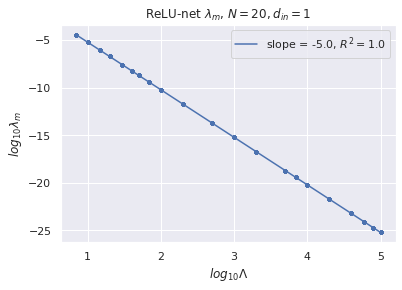

In [ ]:
# Fit the line
x = np.log10(Lambda_list)
y = lambdam4_ReLU_df.mean(1)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
xp = x
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
ax = lambdam4_ReLU_df.plot(legend=False, style='.', c='b')
line = ax.plot(xp, p(xp), label='slope = ' + str(round(z[0], 3)) + ', $R^2 = $' + str(round(r_value**2, 3)), c='b')
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[-1]], [labels[-1]], loc='best')
plt.xlabel("$log_{10}\Lambda$")
plt.ylabel("$log_{10}\lambda_m$")
plt.title("ReLU-net $\lambda_m$, $N = 20, d_{in} = 1$")
plt.show()